In [1]:
import pandas as pd
to=pd.read_csv("/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_ADHD_TotalSymp_and_KSADS.csv")

In [2]:
import os
os.chdir("/scratch/connectome/jubin/ABCD-3DCNN/STEP_4_Multimodal-Learning/MultiChannel-Learning/contrastive_learning")

In [14]:
to

,subjectkey,age,sex,race.ethnicity,high.educ,income,married,abcd_site,height,weight,...,Other.Drugs.Use.Disorder.x,Sedative.Hypnotic.or.Anxiolytic.Use.Disorder.x,Other.Specified.Trauma.and.Stressor.Related.Disorder.x,Post.Traumatic.Stress.Disorder.x,HOMICIDAL.IDEATION.AND.BEHAVIOR.x,totalBIS,totalBAS,PPSP_frequency,PPSP_distress,ADHD_TotalSymp_and_KSADS
0,NDARINV005V6D2C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,10.0,22.0,0,0,0
1,NDARINV014RTM1V,115.0,1.0,1.0,19.0,9.0,1.0,17.0,55.350,89.200000,...,0,0,0,0,0,10.0,14.0,1,1,0
2,NDARINV01D03VR7,114.0,2.0,3.0,16.0,4.0,1.0,10.0,57.000,102.000000,...,0,0,0,0,0,9.0,17.0,0,0,0
3,NDARINV01NAYMZH,129.0,1.0,1.0,15.0,9.0,1.0,16.0,60.500,91.000000,...,0,0,0,0,0,10.0,33.0,0,0,0
4,NDARINV01RGTWD2,111.0,2.0,1.0,18.0,8.0,1.0,2.0,51.375,55.500000,...,0,0,0,0,0,8.0,15.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,NDARINVZ9DDWGHW,111.0,1.0,5.0,18.0,6.0,1.0,8.0,54.710,57.600000,...,0,0,0,0,0,5.0,12.0,0,0,1
3908,NDARINVZBAP2DZ2,126.0,1.0,1.0,19.0,10.0,1.0,13.0,53.500,74.000000,...,0,0,0,0,0,7.0,28.0,2,0,1
3909,NDARINVZCCYZY0V,123.0,1.0,1.0,13.0,2.0,3.0,16.0,57.000,118.333333,...,0,0,1,1,1,15.0,29.0,6,13,1
3910,NDARINVZEKA1L7D,116.0,1.0,1.0,18.0,7.0,1.0,13.0,NaN,67.000000,...,0,0,0,0,0,10.0,19.0,4,8,1


In [11]:
from glob import glob
smris = pd.Series(os.listdir("/scratch/connectome/3DCNN/data/1.ABCD/1.1.sMRI_MNI_warped/"))


In [12]:
smris = smris.map(lambda x:x.split(".")[0])

In [15]:
smris.isin(to.subjectkey).sum()

3741

In [4]:
class arg:
    def __init__(self):
        self.cat_target=['ADHD_TotalSymp_and_KSADS']

In [55]:
args = arg()
args.dataset = 'ABCD'
args.data_type = ['T1_MNI']
args.num_target=[]
args.debug=None
args.cv=None
args.tissue=None
args.val_size=0.1
args.test_size=0.1
args.N=None
args.balanced_split=None
args.num_normalize=None
args.filter=[]
args.resize=(64,64,64)
args.transform=[]
args.augmentation=[]
args.balanced_split='ADHD'

In [84]:
import os
import re
import glob
import random

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
from monai.transforms import (AddChannel, Compose, CenterSpatialCrop, Flip, RandAffine,
                              RandFlip, RandRotate90, Resize, ScaleIntensity, ToTensor)
from monai.data import ImageDataset, NibabelReader

from dataloaders.custom_transform import MaskTissue
from dataloaders.custom_dataset import MultiModalImageDataset
from dataloaders.preprocessing import preprocessing_cat, preprocessing_num

ABCD_data_dir = {
    'fmriprep':'/scratch/connectome/3DCNN/data/1.ABCD/1.sMRI_fmriprep/preprocessed_masked/',    
    'T1_MNI':'/scratch/connectome/3DCNN/data/1.ABCD/1.1.sMRI_MNI_warped/',
    'freesurfer':'/scratch/connectome/3DCNN/data/1.ABCD/2.sMRI_freesurfer/',
    'freesurfer_256':'/scratch/connectome/3DCNN/data/1.ABCD/2.2.sMRI_freesurfer_256/',
    'FA_unwarpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.1.FA_unwarpped_nii/',
    'FA_warpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.2.FA_warpped_nii/',
    'MD_unwarpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.3.MD_unwarpped_nii/',
    'MD_warpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.4.MD_warpped_nii/',
    'RD_unwarpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.5.RD_unwarpped_nii/',
    'RD_warpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.6.RD_warpped_nii/',
    '5tt_warped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.7.5tt_warped_nii/',
    'freesurfer_crop_resize128':'/home/connectome/jubin/3DCNN/ABCD/freesurfer_crop_resize128/',
    'FA_crop_resize128':'/home/connectome/jubin/3DCNN/ABCD/FA_crop_resize128/',
    'T1_MNI_resize128':'/home/connectome/jubin/3DCNN/ABCD/T1_MNI_resize128/',
    'FA_MNI_resize128':'/home/connectome/jubin/3DCNN/ABCD/FA_MNI_resize128/',
    'T1_MNI_resize_areamode':'/scratch/connectome/jubin/T1_MNI_resize128_areamode/',
    'FA_MNI_resize_areamode':'/scratch/connectome/jubin/FA_MNI_resize128_areamode/'
}

ABCD_phenotype_dir = {
    'total':'/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_phenotype_total.csv',
    'ADHD_case':'/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_ADHD.csv',
    'suicide_case':'/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_suicide_case.csv',
    'suicide_control':'/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_suicide_control.csv',
    'BMI':'/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/BMI_prediction/ABCD_phenotype_total.csv',
    'ADHD_TotalSymp_and_KSADS':"/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_ADHD_TotalSymp_and_KSADS.csv",
    'ADHD_TotalSymp_and_KSADS_and_CBCL':"/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_ADHD_TotalSymp_and_KSADS_and_CBCL.csv"
}

UKB_data_dir = '/scratch/connectome/3DCNN/data/2.UKB/1.sMRI_fs_cropped/'
UKB_phenotype_dir = '/scratch/connectome/3DCNN/data/2.UKB/2.demo_qc/UKB_phenotype.csv'


def case_control_count(labels, dataset_type, args):
    if args.cat_target:
        for cat_target in args.cat_target:
            curr_cnt = labels[cat_target].value_counts()
            print(f'In {dataset_type},\t"{cat_target}" contains {curr_cnt[1]} CASE and {curr_cnt[0]} CONTROL')

            
def loading_images(image_dir, args):
    image_files = pd.DataFrame()
    data_types = args.data_type if (args.tissue == None) else args.data_type + ['5tt_warped_nii']
    for brain_modality in data_types:
        curr_dir = image_dir[brain_modality]
        curr_files = pd.DataFrame({brain_modality:glob.glob(curr_dir+'*[yz]')}) # to get .npy(sMRI) & .nii.gz(dMRI) files
        curr_files[subjectkey] = curr_files[brain_modality].map(lambda x: x.split("/")[-1].split('.')[0].split('sub-')[-1])
        if args.dataset == 'UKB':
            curr_files[subjectkey] = curr_files[subjectkey].map(int)
        curr_files.sort_values(by=subjectkey, inplace=True)
        
        if len(image_files) == 0:
            image_files = curr_files
        else:
            image_files = pd.merge(image_files, curr_files, how='inner', on=subjectkey)
            
    if args.debug:
        image_files = image_files[:160]
        
    return image_files


def get_available_subjects(subject_data, args):
    case  = pd.read_csv(ABCD_phenotype_dir['ADHD_case'])[subjectkey]
    control = pd.read_csv(ABCD_phenotype_dir['suicide_control'])[subjectkey]
    filtered_subjectkey = pd.concat([case,control]).reset_index(drop=True)
    subject_data = subject_data[subject_data[subjectkey].isin(filtered_subjectkey)]
    
    return subject_data


def filter_phenotype(subject_data, filters):
    for fil in filters:
        fil_name, fil_option = fil.split(':')
        fil_option = np.float64(fil_option)
        subject_data = subject_data[subject_data[fil_name] == fil_option]
        
    return subject_data


def loading_phenotype(phenotype_dir, target_list, args):
    col_list = target_list + [subjectkey]

    ## get subject ID and target variables
    subject_data = pd.read_csv(phenotype_dir)
#     subject_data = subject_data.loc[:,col_list]
    if 'Attention.Deficit.Hyperactivity.Disorder.x' in target_list:
        subject_data = get_available_subjects(subject_data, args)
    subject_data = filter_phenotype(subject_data, args.filter)
    subject_data = subject_data.sort_values(by=subjectkey)
#     subject_data = subject_data.dropna(axis = 0)
    subject_data = subject_data.reset_index(drop=True)

    ### preprocessing categorical variables and numerical variables
    subject_data = preprocessing_cat(subject_data, args)
    if args.num_normalize == True:
        subject_data = preprocessing_num(subject_data, args)
    
    return subject_data


def make_balanced_testset(il, num_total, args):
    if args.balanced_split.endswith("csv"):        
        predefined_set = pd.read_csv('/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/'+args.balanced_split)
        num_test = round(len(predefined_set)*args.test_size)
        num_train = round(len(predefined_set)*(1-args.val_size-args.test_size))
        num_val = num_total - num_train - num_test
        test_idx = il[il.subjectkey.isin(predefined_set['subjectkey'][-num_test:])].index
        train_idx = il[il.subjectkey.isin(predefined_set['subjectkey'][:num_train])].index
        val_idx = list(set(il.index) - set(train_idx) - set(test_idx))
        if args.N != None:
            train_idx = train_idx[:args.N]
            num_train = len(train_idx)
        imageFiles_labels = pd.concat([il.iloc[train_idx],il.iloc[val_idx],il.iloc[test_idx]])
        
    elif len(args.cat_target) > 0:
        num_test = round(num_total*args.test_size)
        num_val = round(num_total*args.val_size)
        num_train = num_total - num_val - num_test
        n_case = num_test//2
        n_control = num_test - n_case
        t_case, rest_case = np.split(il[il[args.cat_target[0]]==0], (n_case,))
        t_control, rest_control = np.split(il[il[args.cat_target[0]]==1],(n_control,))

        test = pd.concat((t_case, t_control))
        rest = pd.concat((rest_case, rest_control))

        test = test.sort_values(by=subjectkey)
        rest = rest.sort_values(by=subjectkey)

        imageFiles_labels = pd.concat((rest,test)).reset_index(drop=True)
#     elif len(args.num_target) > 0:    
    
    return num_train, num_val, imageFiles_labels


# defining train,val, test set splitting function
def partition_dataset(imageFiles_labels, target_list, args):
    ## Random shuffle according to args.seed -> Disable.
#     imageFiles_labels = imageFiles_labels.sample(frac=1).reset_index(drop=True)
    
    ## Dataset split    
    num_total = len(imageFiles_labels)
    num_train = int(num_total*(1 - args.val_size - args.test_size))
    num_val = int(num_total*args.val_size) if args.cv == None else int((num_total-num_test)/5)
    num_test = int(num_total*args.test_size)
    
#     num_test = int(num_total*args.test_size)
#     num_val = int(num_total*args.val_size) if args.cv == None else int((num_total-num_test)/5)
#     num_train = num_total - (num_val+num_test)
    
    if args.balanced_split:
        num_train, num_val, imageFiles_labels = make_balanced_testset(imageFiles_labels, num_total, args)
    images = imageFiles_labels[args.data_type]
    labels = imageFiles_labels#[target_list].to_dict('records')
    
    ## split dataset by 5-fold cv or given split size
    if args.cv == None:
        images_train, images_val, images_test = np.split(images, [num_train, num_train+num_val]) # revising
        labels_train, labels_val, labels_test = np.split(labels, [num_train, num_train+num_val])
    else:
        split_points = [num_val, 2*num_val, 3*num_val, 4*num_val, num_total-num_test]
        images_total, labels_total = np.split(images, split_points), np.split(labels, split_points)
        images_test, labels_test = images_total.pop(), labels_total.pop()
        images_val, labels_val = images_total.pop(args.cv-1), labels_total.pop(args.cv-1)
        images_train, labels_train = np.concatenate(images_total), np.concatenate(labels_total)
        num_train, num_val = images_train.shape[0], images_val.shape[0]
        
    print(f"Total subjects={len(images)}, train={len(images_train)}, val={len(images_val)}, test={len(images_test)}")

    ## Define transform function
    resize = tuple(args.resize)
    default_transforms = [ScaleIntensity(), AddChannel(), Resize(resize), ToTensor()] 
    
    if 'resize128' in args.data_type[0]:
        default_transforms.pop(2)
        args.resize = (128,128,128)
    if 'crop' in args.transform:
        default_transforms.insert(2, CenterSpatialCrop(192))
    if args.tissue:
        dMRI_transform = [MaskTissue(imageFiles_labels['5tt_warped_nii'], args.tissue)]
        dMRI_transform += default_transforms
        
    aug_transforms = []
    if 'shift' in args.augmentation:
        aug_transforms.append(RandAffine(prob=0.1, translate_range=(0, args.resize[0]//50),
                                         padding_mode='zeros', spatial_size=args.resize, cache_grid=True))
    elif 'flip' in args.augmentation:
        aug_transforms.append(RandFlip(prob=0.1, spatial_axis=0))
    
    train_transforms, val_transforms, test_transforms = [], [], []
    for brain_modality in args.data_type:
        curr_transform = dMRI_transform if args.tissue else default_transforms
        train_transforms.append(Compose(curr_transform + aug_transforms))
        val_transforms.append(Compose(curr_transform))
        test_transforms.append(Compose(curr_transform))
    
    ## make splitted dataset
    train_set = MultiModalImageDataset(image_files=images_train, labels=labels_train, transform=train_transforms)
    val_set = MultiModalImageDataset(image_files=images_val, labels=labels_val, transform=val_transforms)
    test_set = MultiModalImageDataset(image_files=images_test, labels=labels_test, transform=test_transforms)

    partition = {}
    partition['train'] = train_set
    partition['val'] = val_set
    partition['test'] = test_set

#     case_control_count(labels_train, 'train', args)
#     case_control_count(labels_val, 'validation', args)
#     case_control_count(labels_test, 'test', args)

    return partition

def setting_dataset(args):
    subjectkey = 'subjectkey' if args.dataset == 'ABCD' else 'eid'
    image_dir = ABCD_data_dir if args.dataset == 'ABCD' else UKB_data_dir
    if set(['BMI','BMI_sds']) & set(args.num_target):
        phenotype = 'BMI'
    elif 'ADHD_TotalSymp_and_KSADS' in args.cat_target:
        phenotype = 'ADHD_TotalSymp_and_KSADS'
    elif 'ADHD_TotalSymp_and_KSADS_and_CBCL' in args.cat_target:
        phenotype = 'ADHD_TotalSymp_and_KSADS_and_CBCL'
    else:
        phenotype = 'total'
    phenotype_dir = ABCD_phenotype_dir[phenotype] if args.dataset == 'ABCD' else UKB_phenotype_dir
    
    return subjectkey, image_dir, phenotype_dir

def make_dataset(args):
    global subjectkey
    subjectkey, image_dir, phenotype_dir = setting_dataset(args)
    target_list = args.cat_target + args.num_target
    
    image_files = loading_images(image_dir, args)
    subject_data = loading_phenotype(phenotype_dir, target_list, args)

    # combining image files & labels
    imageFiles_labels = pd.merge(subject_data, image_files, how='inner', on=subjectkey)

    # partitioning dataset and preprocessing (change the range of categorical variables and standardize numerical variables)
    partition = partition_dataset(imageFiles_labels, target_list, args)
    print("*** Making a dataset is completed *** \n")
    
    return partition, subject_data

def make_dataloaders(partition, args):
    def seed_worker(worker_id):
        torch.manual_seed(args.seed)
        np.random.seed(args.seed)
        random.seed(args.seed)
    g = torch.Generator()
    g.manual_seed(args.seed)
    
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=args.num_workers,
                                              worker_init_fn=seed_worker,
                                              generator=g)
    
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.val_batch_size,
                                            shuffle=False,
                                            pin_memory=True,
                                            num_workers=args.num_workers,
                                            worker_init_fn=seed_worker,
                                            generator=g)   
    
    return trainloader, valloader


In [85]:
par, subj = make_dataset(args)

Total subjects=3741, train=2993, val=374, test=374
*** Making a dataset is completed *** 



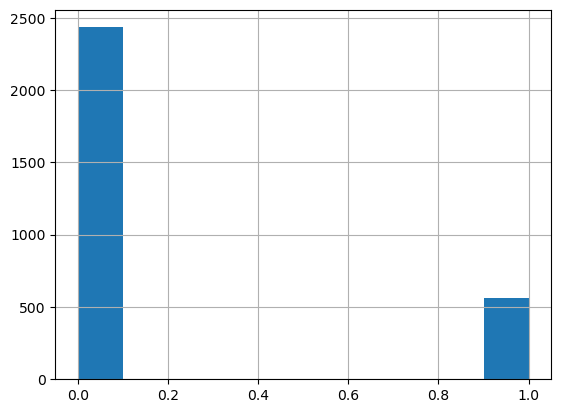

In [98]:
par['train'].labels['ADHD_TotalSymp_and_KSADS'].hist()

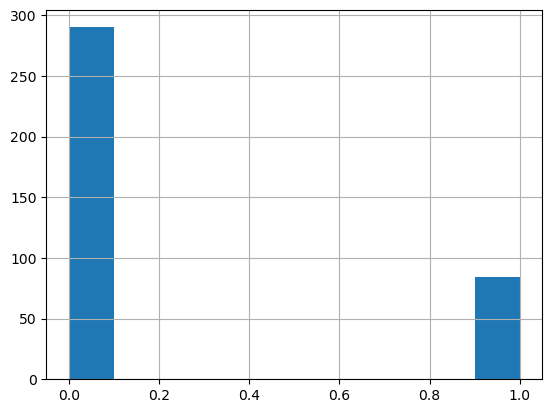

In [99]:
par['val'].labels['ADHD_TotalSymp_and_KSADS'].hist()

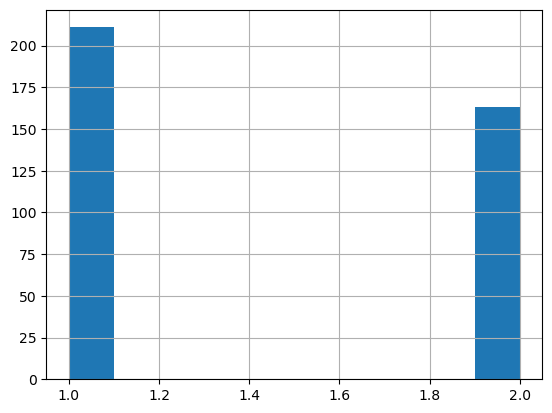

In [97]:
par['test'].labels.sex.hist()

In [65]:
d=dict()

In [60]:
l=[]
for d in par['test'].labels:
    l += [*d.values()]

In [61]:
l = pd.Series(l)

In [62]:
l.value_counts()

1    187
0    187
dtype: int64

In [28]:
pd.read_csv("/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_ADHD.csv").subjectkey

0       NDARINV00BD7VDC
1       NDARINV00CY2MDM
2       NDARINV00LJVZK2
3       NDARINV00U4FTRU
4       NDARINV0182J779
             ...       
2501    NDARINVZCGL10MP
2502    NDARINVZE3C6X7E
2503    NDARINVZEB043HN
2504    NDARINVZEKA1L7D
2505    NDARINVZER4ED76
Name: subjectkey, Length: 2506, dtype: object

In [29]:
print(ad.shape,con.shape)

(2506, 118) (3108, 45)


In [30]:
import glob
images = glob.glob('/scratch/connectome/3DCNN/data/1.ABCD/3.2.FA_warpped_nii/*')
images_subjectkeys=pd.Series(map(lambda x: x.split("/")[-1].split(".")[0],images),name='subjectkey')
images_subjectkeys[:3]

0    NDARINV89B7M962
1    NDARINV6ZU9NKBV
2    NDARINVLPMG7ZFU
Name: subjectkey, dtype: object

In [31]:
for c in con.columns:
    if 'Attention' in c:print(c)

Unspecified.Attention.Deficit.Hyperactivity.Disorder.x
Attention.Deficit.Hyperactivity.Disorder.x


In [32]:
sjk=pd.concat([ad.subjectkey,con.subjectkey]).reset_index(drop=True)

In [38]:
sjk

0       NDARINV00BD7VDC
1       NDARINV00CY2MDM
2       NDARINV00LJVZK2
3       NDARINV00U4FTRU
4       NDARINV0182J779
             ...       
5609    NDARINVZXPAWB32
5610    NDARINVZZ35KHXP
5611    NDARINVZZ6ZJ2KY
5612    NDARINVZZNX6W2P
5613    NDARINVZZZP87KR
Name: subjectkey, Length: 5614, dtype: object

In [33]:
newdf=to[to.subjectkey.isin(sjk)==True]

In [34]:
newdf.subjectkey.isin(images_subjectkeys).value_counts()

True     3993
False    1621
Name: subjectkey, dtype: int64

In [35]:
images2 = glob.glob('/scratch/connectome/3DCNN/data/1.ABCD/2.sMRI_freesurfer/*')
images_subjectkeys2=pd.Series(map(lambda x: x.split("/")[-1].split(".")[0],images2),name='subjectkey')
images_subjectkeys2[:3]

0    NDARINVBZJGG4AN
1    NDARINVXPZGM0LG
2    NDARINVU9C36KFY
Name: subjectkey, dtype: object

In [36]:
smris=newdf[newdf.subjectkey.isin(images_subjectkeys2)==True]
swithd=smris[smris.subjectkey.isin(images_subjectkeys)==True]
swithd['Attention.Deficit.Hyperactivity.Disorder.x'].value_counts()

0.0    2255
1.0    1736
Name: Attention.Deficit.Hyperactivity.Disorder.x, dtype: int64

In [41]:
pd.merge(pd.merge(ad.subjectkey,to.subjectkey),newdf.subjectkey)

,subjectkey
0,NDARINV00BD7VDC
1,NDARINV00CY2MDM
2,NDARINV00LJVZK2
3,NDARINV00U4FTRU
4,NDARINV0182J779
...,...
2501,NDARINVZCGL10MP
2502,NDARINVZE3C6X7E
2503,NDARINVZEB043HN
2504,NDARINVZEKA1L7D


In [57]:
# revising
ABCD_data_dir = {
    'fmriprep':'/scratch/connectome/3DCNN/data/1.ABCD/1.sMRI_fmriprep/preprocessed_masked/',
    'freesurfer':'/scratch/connectome/3DCNN/data/1.ABCD/2.sMRI_freesurfer/',
    'FA_unwarpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.1.FA_unwarpped_nii/',
    'FA_warpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.2.FA_warpped_nii/',
    'MD_unwarpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.3.MD_unwarpped_nii/',
    'MD_warpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.4.MD_warpped_nii/',
    'RD_unwarpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.5.RD_unwarpped_nii/',
    'RD_warpped_nii':'/scratch/connectome/3DCNN/data/1.ABCD/3.6.RD_warpped_nii/'
}

ABCD_phenotype_dir = {
    'total':'/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_phenotype_total.csv',
    'ADHD_case':'/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_ADHD.csv',
    'suicide_case':'/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_suicide_case.csv',
    'suicide_control':'/scratch/connectome/3DCNN/data/1.ABCD/4.demo_qc/ABCD_suicide_control.csv'
}


    


col_list = ['Attention.Deficit.Hyperactivity.Disorder.x','subjectkey']
dtypes = ['freesurfer','MD_warpped_nii']
### get subject ID and target variables
subject_data = pd.read_csv(ABCD_phenotype_dir['total'])
subject_data = subject_data.loc[:,col_list]

case  = pd.read_csv(ABCD_phenotype_dir['ADHD_case']).subjectkey
control = pd.read_csv(ABCD_phenotype_dir['suicide_control']).subjectkey
filtered_subjectkey = pd.concat([case,control]).reset_index(drop=True)
for data_type in dtypes:
    data_files = glob.glob(ABCD_data_dir[data_type]+'*')
    print(data_files[:3])
    data_subjectkey = pd.Series(map(lambda x: x.split("/")[-1].split(".")[0],data_files),name='subjectkey')
    print(data_subjectkey[:3])
    filtered_subjectkey = pd.merge(filtered_subjectkey,data_subjectkey)
    print(filtered_subjectkey[:3])    

subject_data[subject_data.subjectkey.isin(filtered_subjectkey.subjectkey)==True]

# subject_data = subject_data.sort_values(by='subjectkey')
# subject_data = subject_data.dropna(axis = 0)
# subject_data = subject_data.reset_index(drop=True)

['/scratch/connectome/3DCNN/data/1.ABCD/2.sMRI_freesurfer/NDARINVBZJGG4AN.npy', '/scratch/connectome/3DCNN/data/1.ABCD/2.sMRI_freesurfer/NDARINVXPZGM0LG.npy', '/scratch/connectome/3DCNN/data/1.ABCD/2.sMRI_freesurfer/NDARINVU9C36KFY.npy']
0    NDARINVBZJGG4AN
1    NDARINVXPZGM0LG
2    NDARINVU9C36KFY
Name: subjectkey, dtype: object
        subjectkey
0  NDARINV00BD7VDC
1  NDARINV00CY2MDM
2  NDARINV00LJVZK2
['/scratch/connectome/3DCNN/data/1.ABCD/3.4.MD_warpped_nii/NDARINV89B7M962.nii.gz', '/scratch/connectome/3DCNN/data/1.ABCD/3.4.MD_warpped_nii/NDARINV6ZU9NKBV.nii.gz', '/scratch/connectome/3DCNN/data/1.ABCD/3.4.MD_warpped_nii/NDARINVLPMG7ZFU.nii.gz']
0    NDARINV89B7M962
1    NDARINV6ZU9NKBV
2    NDARINVLPMG7ZFU
Name: subjectkey, dtype: object
        subjectkey
0  NDARINV00BD7VDC
1  NDARINV00CY2MDM
2  NDARINV00LJVZK2


,Attention.Deficit.Hyperactivity.Disorder.x,subjectkey
3,1.0,NDARINV00BD7VDC
4,1.0,NDARINV00CY2MDM
8,1.0,NDARINV00LJVZK2
11,1.0,NDARINV00U4FTRU
15,0.0,NDARINV014RTM1V
...,...,...
10138,0.0,NDARINVV5MHL75K
10142,1.0,NDARINVV5XX9GEF
10148,0.0,NDARINVV6KFJX12
10150,1.0,NDARINVV6MZ4VB1


In [56]:
filtered_subjectkey

,subjectkey
0,NDARINV00BD7VDC
1,NDARINV00CY2MDM
2,NDARINV00LJVZK2
3,NDARINV00U4FTRU
4,NDARINV0182J779
...,...
3986,NDARINVV54EMBM7
3987,NDARINVV56VCMTJ
3988,NDARINVV5MHL75K
3989,NDARINVV6KFJX12


In [55]:
subject_data

,Attention.Deficit.Hyperactivity.Disorder.x,subjectkey
0,0.0,NDARINV003RTV85
1,0.0,NDARINV005V6D2C
2,0.0,NDARINV007W6H7B
3,1.0,NDARINV00BD7VDC
4,1.0,NDARINV00CY2MDM
...,...,...
11870,0.0,NDARINVZZNX6W2P
11871,0.0,NDARINVZZPKBDAC
11872,1.0,NDARINVZZZ2ALR6
11873,1.0,NDARINVZZZNB0XC
